In [1]:
import sys
print(sys.version)

3.9.17 (main, Jul  5 2023, 20:41:20) 
[GCC 11.2.0]


In [2]:
# pip install fastai

In [3]:
import fastai
print(fastai.__version__)  # Check the installed version

2.7.18


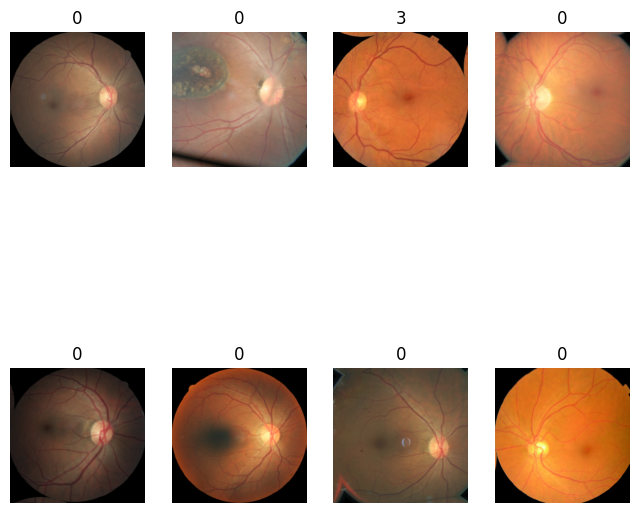

In [10]:
# Import required libraries
from fastai.vision.all import *
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score

# Define the DataBlock
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),  # Input: Image, Target: Category
    get_items=get_image_files,  # Get all image files in the path
    splitter=RandomSplitter(valid_pct=0.2, seed=42),  # Train/valid split
    get_y=parent_label,  # Labels from parent folder names
    item_tfms=Resize(460),  # Resize to 460 before batching
    batch_tfms=aug_transforms(size=224)  # Resize to 224 with augmentations
)

# Load the DataLoaders
path = Path('data/train15')
dls = dblock.dataloaders(path, bs=8, num_workers=0)

# Show a batch of images
dls.show_batch(max_n=9, figsize=(8, 8))

In [6]:
class PretrainedEyeDiseaseClassifier(nn.Module):
    def __init__(self, pretrained_model='vgg16', num_classes=5):
        super(PretrainedEyeDiseaseClassifier, self).__init__()
        if pretrained_model == 'vgg16':
            self.model = models.vgg16(pretrained=True)
            self.model.classifier[6] = nn.Linear(4096, num_classes)
        elif pretrained_model == 'resnet18':
            self.model = models.resnet18(pretrained=True)
            num_ftrs = self.model.fc.in_features
            self.model.fc = nn.Linear(num_ftrs, num_classes)
        else:
            raise ValueError('Unsupported pretrained model. Choose vgg16 or resnet18.')

    def forward(self, x):
        return self.model(x)

In [8]:
from sklearn.metrics import precision_score, recall_score

# Custom precision with zero_division handling
def precision_macro(preds, targs):
    preds = preds.argmax(dim=1).cpu().numpy()
    targs = targs.cpu().numpy()
    return precision_score(targs, preds, average='macro', zero_division=1)

# Custom recall (optional, keeping it aligned with precision handling)
def recall_macro(preds, targs):
    preds = preds.argmax(dim=1).cpu().numpy()
    targs = targs.cpu().numpy()
    return recall_score(targs, preds, average='macro', zero_division=1)

In [ ]:
# Initialize the VGG16 Model
model = PretrainedEyeDiseaseClassifier(pretrained_model='vgg16', num_classes=5)

# Create the Learner
learn = Learner(
    dls,
    model,
    loss_func=CrossEntropyLossFlat(),
    opt_func=partial(Adam, lr=0.001),
    metrics=[accuracy, precision_macro, recall_macro]
)

# Train the Model
learn.fit(5)  # Train for 5 epochs

epoch,train_loss,valid_loss,accuracy,precision_macro,recall_macro,time
0,0.897840,0.852179,0.741495,0.902679,0.456095,3:10:04
1,0.868085,0.848532,0.741495,0.902679,0.456095,2:35:15
2,0.823414,0.850235,0.741495,0.902679,0.456095,2:31:16


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



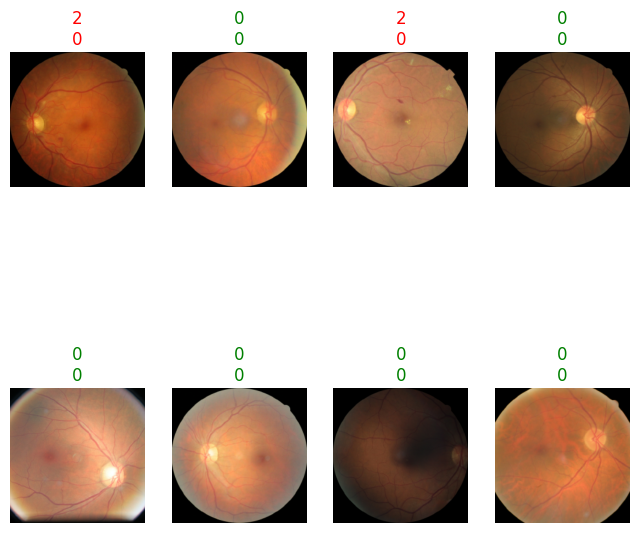

In [12]:
learn.show_results(max_n=9, figsize=(8, 8))

In [13]:
# Save the state_dict (model parameters)
torch.save(model.state_dict(), "models/v1.5_vgg16_model.pth")